# Simple Image Classifier

Implementing Chapter 2 of [Programming PyTorch for Deep Learning](http://shop.oreilly.com/product/0636920216032.do)

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Architecture

This is a simple three layer network: an input and hidden layer, with a two-node output layer.

It is *fully-connected* in that each node in each layer affects every node the next layer.

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.input_layer = nn.Linear(12288, 84)
        self.hidden_layer = nn.Linear(84, 50)
        self.output_layer = nn.Linear(50, 2)
        
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

In [3]:
simple = SimpleNN()

In [4]:
optimizer = optim.Adam(simple.parameters(), lr=0.0001)

In [18]:
def train(model, optimizer, loss_fn, training_loader, validation_loader, epochs, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        validation_loss = 0.0
        model.train()
        for (inputs, targets) in training_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(training_loader)
        
        number_correct = 0
        number_examples = 0
        model.eval()
        for (inputs, targets) in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            validation_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], targets).view(-1)
            number_correct += torch.sum(correct).item()
            number_examples += correct.shape[0]
        validation_loss /= len(validation_loader)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch, 
            training_loss,
            validation_loss, 
            number_correct / number_examples))

## Data

Using the [technique from lesson 2](https://github.com/dpapathanasiou/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) of the [Fast.ai course](https://course.fast.ai/), get a list of image urls with some in-browser javascript:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [6]:
from pathlib import Path
import urllib.request

def fetch_images(image_url_list, target):
    data_file = Path(image_url_list)
    for i, url in enumerate(data_file.read_text().splitlines()):
        image_file = Path(target) / str(i) # TODO: determine file extension, since ImageFolders needs it
        urllib.request.urlretrieve(url, image_file)

Instead of `cat` versus `fish`, this notebook will attempt [aikido](https://en.wikipedia.org/wiki/Aikido) verus [judo](https://en.wikipedia.org/wiki/Judo)

In [9]:
fetch_images("./data/aikido_train.csv", "./data/train/aikido")
fetch_images("./data/aikido_validate.csv", "./data/validate/aikido")
fetch_images("./data/aikido_test.csv", "./data/test/aikido")

In [12]:
fetch_images("./data/judo_train.csv", "./data/train/judo")
fetch_images("./data/judo_validate.csv", "./data/validate/judo")
fetch_images("./data/judo_test.csv", "./data/test/judo")

In [5]:
import torchvision
from torchvision import transforms

In [6]:
image_transform = transforms.Compose(
    [transforms.Resize((64,64)), 
     transforms.ToTensor(),    
     transforms.Normalize(mean=[0.485, 0.456, 0.406],                    
                          std=[0.229, 0.224, 0.225])])

In [7]:
training_data   = torchvision.datasets.ImageFolder(root="./data/train",    transform=image_transform)
validation_data = torchvision.datasets.ImageFolder(root="./data/validate", transform=image_transform)
test_data       = torchvision.datasets.ImageFolder(root="./data/test",     transform=image_transform)

In [8]:
from torch.utils.data import DataLoader

In [9]:
batch_size = 10
training_loader   = DataLoader(training_data, batch_size=batch_size)
validation_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader       = DataLoader(test_data, batch_size=batch_size)

## Train and evaluate

In [13]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [15]:
train(simple, optimizer, torch.nn.CrossEntropyLoss(), training_loader, validation_loader, 20, device)

Epoch: 0, Training Loss: 0.31, Validation Loss: 0.36, accuracy = 0.82
Epoch: 1, Training Loss: 0.26, Validation Loss: 0.34, accuracy = 0.80
Epoch: 2, Training Loss: 0.18, Validation Loss: 0.34, accuracy = 0.82
Epoch: 3, Training Loss: 0.11, Validation Loss: 0.34, accuracy = 0.82
Epoch: 4, Training Loss: 0.08, Validation Loss: 0.34, accuracy = 0.82
Epoch: 5, Training Loss: 0.06, Validation Loss: 0.34, accuracy = 0.82
Epoch: 6, Training Loss: 0.05, Validation Loss: 0.34, accuracy = 0.82
Epoch: 7, Training Loss: 0.04, Validation Loss: 0.34, accuracy = 0.80
Epoch: 8, Training Loss: 0.03, Validation Loss: 0.34, accuracy = 0.80
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.34, accuracy = 0.80
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.34, accuracy = 0.80
Epoch: 11, Training Loss: 0.02, Validation Loss: 0.34, accuracy = 0.80
Epoch: 12, Training Loss: 0.02, Validation Loss: 0.34, accuracy = 0.80
Epoch: 13, Training Loss: 0.02, Validation Loss: 0.34, accuracy = 0.80
Epoch: 14, Train

## Predictions

How does the model do against the test set?

In [26]:
def test(model, test_loader, device="cpu"):
    i = 0
    for (inputs, targets) in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1], targets)
        right = len(list(filter(lambda x: x.item(), list(correct))))
        wrong = batch_size - right
        print('Batch {}: {} right vs {} wrong (pct correct {:.2f})'.format(i, right, wrong, (right / batch_size)))
        i += 1

In [19]:
test(simple, test_loader)

Batch 0: 8 right vs 2 wrong (pct correct 0.80)
Batch 1: 9 right vs 1 wrong (pct correct 0.90)
Batch 2: 5 right vs 5 wrong (pct correct 0.50)
Batch 3: 7 right vs 3 wrong (pct correct 0.70)


### Addendum: discovering the optimal learning rate

Chapter 4 covers `Transfer Learning` and explains a technique for finding the optimal learning rate based on [this paper](https://arxiv.org/abs/1506.01186)

In [10]:
import math

def find_lr(model, optimizer, loss_fn, train_loader, device, init_value=1e-8, final_value=10.0):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
        
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

In [14]:
logs, losses = find_lr(simple, optimizer, nn.CrossEntropyLoss(), training_loader, device)

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

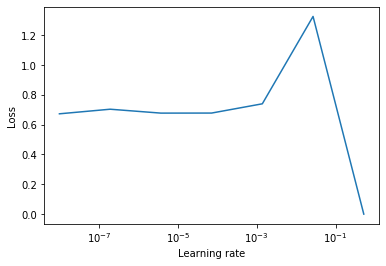

In [16]:
plt.plot(logs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [23]:
logs, losses

([1e-08,
  1.93069772888325e-07,
  3.7275937203149393e-06,
  7.196856730011518e-05,
  0.001389495494373137,
  0.026826957952797242,
  0.5179474679231207],
 [0.6722691655158997,
  0.7030429840087891,
  0.6768912672996521,
  0.6772599816322327,
  0.7393165230751038,
  1.324784755706787,
  8.046303264563903e-06])

In [39]:
# try using this found rate in training
simple2 = SimpleNN()
found_lr = 7.196856730011518e-05
optimizer2 = optim.Adam(simple2.parameters(), lr=found_lr)

In [40]:
train(simple2, optimizer2, torch.nn.CrossEntropyLoss(), training_loader, validation_loader, 20, device)

Epoch: 0, Training Loss: 0.68, Validation Loss: 0.49, accuracy = 0.80
Epoch: 1, Training Loss: 0.40, Validation Loss: 0.40, accuracy = 0.80
Epoch: 2, Training Loss: 0.31, Validation Loss: 0.39, accuracy = 0.80
Epoch: 3, Training Loss: 0.23, Validation Loss: 0.38, accuracy = 0.80
Epoch: 4, Training Loss: 0.18, Validation Loss: 0.37, accuracy = 0.80
Epoch: 5, Training Loss: 0.13, Validation Loss: 0.37, accuracy = 0.80
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.36, accuracy = 0.82
Epoch: 7, Training Loss: 0.08, Validation Loss: 0.36, accuracy = 0.82
Epoch: 8, Training Loss: 0.07, Validation Loss: 0.36, accuracy = 0.85
Epoch: 9, Training Loss: 0.06, Validation Loss: 0.36, accuracy = 0.85
Epoch: 10, Training Loss: 0.05, Validation Loss: 0.36, accuracy = 0.85
Epoch: 11, Training Loss: 0.04, Validation Loss: 0.36, accuracy = 0.85
Epoch: 12, Training Loss: 0.04, Validation Loss: 0.36, accuracy = 0.85
Epoch: 13, Training Loss: 0.03, Validation Loss: 0.36, accuracy = 0.85
Epoch: 14, Train

In [41]:
test(simple2, test_loader)

Batch 0: 7 right vs 3 wrong (pct correct 0.70)
Batch 1: 8 right vs 2 wrong (pct correct 0.80)
Batch 2: 6 right vs 4 wrong (pct correct 0.60)
Batch 3: 8 right vs 2 wrong (pct correct 0.80)
